Visual QA 문제에서 관계형 추론(relational reasoning)을 도출하고자 DeepMind가 제안한 신경망 모델인 `관계 네트워크(Relation Networks, 이하 RN)` 대해서 알아보고자 합니다. 이 모델은 [A simple neural network module for relational reasoning](https://arxiv.org/pdf/1706.01427.pdf)이란 논문에서 소개되었고, 컨볼루션 신경망에 RN를 추가하여 어떻게 객체와 그 관계에 대해 추론하는 지 설명되어 있습니다. 시각기반의 질의응답 문제에 대해 탁월한 성능을 보이고 있다고 합니다.

---

### 관계형 추론이란

관계형 추론(Relational Reasoning)이란 객체와 객체 속성 간의 관계를 추론하는 능력입니다. 아래 그림을 보면 두가지 질문이 있는데, 특정 객체의 속성을 추론하는 것을 비관계형 질문이라고 하고, 객체 간의 관계에 대해서 추론하는 것을 관계형 질문이라고 합니다.

(Ref, [arXiv:1706.01427](https://arxiv.org/abs/1706.01427))
![paper](http://tykimos.github.com/Keras/warehouse/2017-6-17-Relation_Network_paper1.png)

---

### 관계 네트워크(Relation Networks, RN)

DeepMind에서는 이러한 관계형 추론을 할 수 있는 RN을 개발하였습니다. RN은 간단하며, 다른 모델에 쉽게 붙일 수 있고, 유연한 관계형 추론에만 중점을 둘 수 있습니다. RN을 CNN과 LSTM과 결합하여 (본문에서는 RN-augmented architecture라고 표현) visual question answering 문제에 대해서 실험을 하였고, 좋은 결과(기존 모델은 76.6%, 사람이 92.6%, RN 모델 적용한 것이 95.5%)가 나왔다고 합니다. 

(Ref, [arXiv:1706.01427](https://arxiv.org/abs/1706.01427))
![paper](http://tykimos.github.com/Keras/warehouse/2017-6-17-Relation_Network_paper2.png)

---

### RN-augmented Visual QA acrhitecture

RN 모델 자체는 객체 관계만 추론하기 때문에 이미지나 자연어에 대해서는 동작하지 않습니다. 그래서 CNN과 LSTM 등과의 모델에서의 출력을 입력받아 객체를 추출하고 각 객체간의 관계를 추론합니다. 즉 객체를 따로 지정할 필요도 없다고 합니다. 아래는 논문에서 사용한 모델 구성입니다.

(Ref, [arXiv:1706.01427](https://arxiv.org/abs/1706.01427))
![paper](http://tykimos.github.com/Keras/warehouse/2017-6-17-Relation_Network_paper3.png)

입력되는 이미지의 픽셀에서 객체들을 추출하기 위해 CNN이 사용하였습니다. 4개의 컨볼루션 레이어를 통해 크기 d * d의 k개의 feature map이 생성됩니다. k는 최종 컨볼루션 레이어의 커널 수입니다. 총 셀의 개수는 d*d*k가 되는 데, 각 셀은 RN에 대한 객체로 간주되며, 객체는 배경, 특정 객체, 질감, 연결 등을 정보를 담고 있습니다. 이러한 객체 정보는 인코딩된 질문과 함께 RN 모델의 입력이 됩니다.

---

### Implementation

본 스터디에서는 [Alan-Lee123](https://github.com/Alan-Lee123/relation-network/blob/master/README.md) 사이트에서 구현된 케라스 코드를 실행시키면서 분석해보겠습니다. 사용된 데이터셋은 [Cornell NLVR](https://github.com/cornell-lic/nlvr)이라고 불리는 시각기반의 질의응답 데이터셋입니다. 소스 구동하기 위해 아래 몇가지 사안에 대해서 고려해야 합니다.

* 백그라운드는 Tensorflow를 사용해야 함
* 버전에 따라 keras.preprocessing.text.text_to_word_sequence 함수를 재정의해야할 필요가 있음

#### 데이터 전처리

이미지, 질문 등의 데이터를 처리하기 위한 함수 및 객체를 정의합니다.

In [1]:
import json
import numpy as np
import os
from PIL import Image
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# text_to_word_sequence 부분에 패치가 필요하여, text_to_word_sequence 함수를 재정의함
import keras.preprocessing.text

def text_to_word_sequence(text,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True, split=" "):
    if lower: text = text.lower()
    if type(text) == unicode:
        translate_table = {ord(c): ord(t) for c,t in zip(filters, split*len(filters)) }
    else:
        translate_table = maketrans(filters, split * len(filters))
    text = text.translate(translate_table)
    seq = text.split(split)
    return [i for i in seq if i]
    
keras.preprocessing.text.text_to_word_sequence = text_to_word_sequence

EMBEDDING_DIM = 50
tokenizer = Tokenizer()

def load_data(path):
    f = open(path, 'r')
    data = []
    for l in f:
        jn = json.loads(l)
        s = jn['sentence']
        idn = jn['identifier']
        la = int(jn['label'] == 'true')
        data.append([idn, s, la])
    return data

def init_tokenizer(sdata):
    texts = [t[1] for t in sdata]
    tokenizer.fit_on_texts(texts)

def tokenize_data(sdata, mxlen):
    texts = [t[1] for t in sdata]
    seqs = tokenizer.texts_to_sequences(texts)
    seqs = pad_sequences(seqs, mxlen)
    data = {}
    for k in range(len(sdata)):
        data[sdata[k][0]] = [seqs[k], sdata[k][2]]
    return data

def load_images(path, sdata, debug=False):
    data = {}
    cnt = 0
    N = 1000
    for lists in os.listdir(path):
        p = os.path.join(path, lists)
        
        if not os.path.isdir(p): # 자동으로 생성되는 시스템 파일이 있을 경우 오류가 발생하기 때문에, 폴더인지 체크함
            continue
            
        for f in os.listdir(p):
            cnt += 1
            if debug and cnt > N:
                break
            im_path = os.path.join(p, f)
            im = Image.open(im_path)
            im = im.convert('RGB')
            im = im.resize((200, 50))
            im = np.array(im)
            idf = f[f.find('-') + 1:f.rfind('-')]
            data[f] = [im] + sdata[idf]
    ims, ws, labels = [], [], []
    for key in data:
        ims.append(data[key][0])
        ws.append(data[key][1])
        labels.append(data[key][2])
    data.clear()
    idx = np.arange(0, len(ims), 1)
    np.random.shuffle(idx)
    ims = [ims[t] for t in idx]
    ws = [ws[t] for t in idx]
    labels = [labels[t] for t in idx]
    ims = np.array(ims, dtype=np.float32)
    ws = np.array(ws, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return ims, ws, labels

def get_embeddings_index():
    embeddings_index = {}
    path = './warehouse/word2vec/glove.6B.50d.txt'
    f = open(path, 'r')#, errors='ignore')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index


def get_embedding_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

Using TensorFlow backend.


#### 데이터 로딩

앞서 정의한 전처리 함수를 이용하여 이미지 및 질문 데이터를 로딩합니다.

In [2]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding, LSTM, Bidirectional, Lambda, Concatenate, Add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization, regularizers
from keras.optimizers import Adam, RMSprop
import gc

import subprocess
import pickle

mxlen = 32
embedding_dim = 50
lstm_unit = 64
MLP_unit = 128
epochs = 50
batch_size = 256
l2_norm = 0.01

train_json = './warehouse/nlvr/train/train.json'
train_img_folder = './warehouse/nlvr/train/images'
test_json = './warehouse/nlvr/dev/dev.json'
test_img_folder = './warehouse/nlvr/dev/images'

data = load_data(train_json)
init_tokenizer(data)
data = tokenize_data(data, mxlen)
imgs, ws, labels = load_images(train_img_folder, data)
data.clear()

test_data = load_data(test_json)
test_data = tokenize_data(test_data, mxlen)
test_imgs, test_ws, test_labels = load_images(test_img_folder, test_data)
test_data.clear()

imgs_mean = np.mean(imgs)
imgs_std = np.std(imgs - imgs_mean)
imgs = (imgs - imgs_mean) / imgs_std

test_imgs = (test_imgs - imgs_mean) / imgs_std

#### CNN 및 LSTM 모델 구성

이미지를 처리하기 위한 CNN과 질문을 처리하기 위한 LSTM 모델을 정의합니다.

In [3]:
def embedding_layer(word_index, embedding_index, sequence_len):
    embedding_matrix = get_embedding_matrix(word_index, embedding_index)
    return Embedding(len(word_index) + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=sequence_len,
                     trainable=False)

# x는 필터크기
# conv_unit는 커널크기
# 출력은 샘플수, 행, 열, 필터수
def bn_layer(x, conv_unit):
    def f(inputs):
        md = Conv2D(x, (conv_unit, conv_unit), padding='same', kernel_initializer='he_normal')(inputs)
        md = BatchNormalization()(md)
        return Activation('relu')(md)

    return f

def conv_net(inputs):
    model = bn_layer(16, 3)(inputs)
    model = MaxPooling2D((4, 4), 4)(model)
    model = bn_layer(16, 3)(model)
    model = MaxPooling2D((3, 3), 3)(model)
    model = bn_layer(16, 3)(model)
    model = MaxPooling2D((2, 2), 2)(model)
    model = bn_layer(32, 3)(model)
    return model

In [4]:
input1 = Input((50, 200, 3))
input2 = Input((mxlen,))
cnn_features = conv_net(input1)
embedding_layer = embedding_layer(tokenizer.word_index, get_embeddings_index(), mxlen)
embedding = embedding_layer(input2)
# embedding = Embedding(mxlen, embedding_dim)(input2)
bi_lstm = Bidirectional(LSTM(lstm_unit, implementation=2, return_sequences=False,
                             recurrent_regularizer=regularizers.l2(l2_norm), recurrent_dropout=0.25))
lstm_encode = bi_lstm(embedding)
shapes = cnn_features.shape
w, h = shapes[1], shapes[2]

#### RN 모델 구성

CNN을 통해서 나온 feature map을 행과 열로 짤라서, Bi-LSTM으로 인코딩된 질문과 관계를 형성한 뒤 이를 dense 레이어로 구성합니다.

In [5]:
# t 샘플, 행, 열, 필터

def slice_1(t):
    return t[:, 0, :, :]

def slice_2(t):
    return t[:, 1:, :, :]

def slice_3(t):
    return t[:, 0, :]

def slice_4(t):
    return t[:, 1:, :]

slice_layer1 = Lambda(slice_1)
slice_layer2 = Lambda(slice_2)
slice_layer3 = Lambda(slice_3)
slice_layer4 = Lambda(slice_4)

features = []
for k1 in range(w):
    features1 = slice_layer1(cnn_features)
    cnn_features = slice_layer2(cnn_features)
    for k2 in range(h):
        features2 = slice_layer3(features1)
        features1 = slice_layer4(features1)
        features.append(features2)

relations = []
concat = Concatenate()
for feature1 in features:
    for feature2 in features:
        relations.append(concat([feature1, feature2, lstm_encode]))

def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x
    return f

def get_MLP(n):
    r = []
    for k in range(n):
        s = stack_layer([
            Dense(MLP_unit),
            BatchNormalization(),
            Activation('relu')
        ])
        r.append(s)
    return stack_layer(r)

def bn_dense(x):
    y = Dense(MLP_unit)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(0.5)(y)
    return y

g_MLP = get_MLP(3)

mid_relations = []
for r in relations:
    mid_relations.append(g_MLP(r))
combined_relation = Add()(mid_relations)

rn = bn_dense(combined_relation)
rn = bn_dense(rn)
pred = Dense(1, activation='sigmoid')(rn)

구성하는 과정이 조금 복잡할 수 있는데, 2017년 2월에 나왔던 아래 논문을 보면 RN에 대해서 좀 더 상세하게 설명되었습니다. 

(Ref, [arXiv:1702.05068](https://arxiv.org/abs/1702.05068))
![paper](http://tykimos.github.com/Keras/warehouse/2017-6-17-Relation_Network_paper4.png)

#### 모델 조합

지금까지 만든 모델을 조합합니다.

In [6]:
model = Model(inputs=[input1, input2], outputs=pred)
optimizer = Adam(lr=3e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

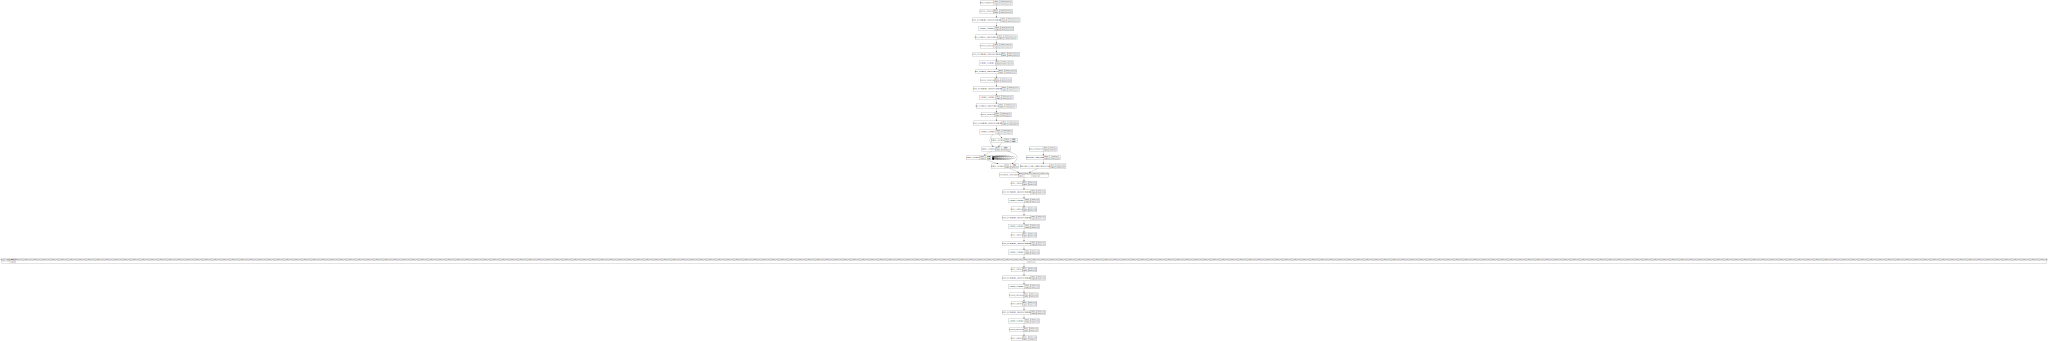

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

아래 그림은 구성된 모델을 도식화 한 것입니다. 잘 확대해서 보시기 바랍니다. 

![svg](http://tykimos.github.com/Keras/warehouse/2017-6-17-Relation_Network_model.svg)

#### 모델 학습하기

구성된 모델을 훈련셋으로 학습합니다. 검증셋은 시험셋으로 사용하였네요.

In [8]:
model.fit([imgs, ws], labels, validation_data=[[test_imgs, test_ws], test_labels],
          epochs=epochs, batch_size=batch_size)

Train on 74460 samples, validate on 5934 samples
Epoch 1/50
 4096/74460 [>.............................] - ETA: 3146s - loss: 1.4937 - acc: 0.4956

KeyboardInterrupt: 

#### 평가

훈련 정확도는 93%이상이나 시험셋으로 평가했을 때는 51% 정도 나왔습니다.

In [ ]:
### Test
scores = model.evaluate([test_imgs, test_ws], test_labels, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

---

### 결론

상당히 오버피팅이 되었는데, 무슨 이유인지 차근히 살펴봐야겠습니다. 참고로 Pytorch로 구현된 [코드](https://github.com/kimhc6028/relational-networks)도 보입니다. 여기서는 결과가 관계형 질문 정확도가 89%, 비관계형 질문 정확도가 99%이라고 되어있네요.

같은 시기에 DeepMind에서 [Visual Interaction Networks](https://arxiv.org/abs/1706.01433)이란 논문도 나왔습니다. 아래 그림을 보시면 6 프레임을 입력하여 200프레임을 예측한 결과인데, 상당히 잘 맞습니다. 

(Ref, [DeepMind](https://deepmind.com/blog/neural-approach-relational-reasoning/))
![gif](http://tykimos.github.com/Keras/warehouse/2017-6-17-Relation_Network_paper5.gif)

Visual Interaction Network는 시각적 모듈과 물리적 추론 모듈의 두 가지 메커니즘으로 구성되며, 시각적 장면 처리는 물론 미래에 어떤 일이 일어날 지 예측할 수있는 암묵적 시스템 규칙(예를 들어 물리 시스템)을 학습한다고 합니다. 현상만 잘 학습시키면, 딥러닝 기반의 물리 엔진이 만들어질 기세입니다. 다양한 활용 사례를 기대해봅니다.

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)